# Collaborative filtering from scratch

In [24]:
from fastai.tabular.all import *
from fastai.collab import *

In [25]:
path  = untar_data(URLs.ML_100k)

In [26]:
Path.BASE_PATH = path

In [27]:
path/'u.data'

Path('u.data')

In [28]:
ratings = pd.read_csv(path/'u.data', sep='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
movies = pd.read_csv(path/'u.item', sep='|', header=None, encoding='latin-1', names=['movie', 'title'], usecols=(0,1))
movies

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [30]:
mr = ratings.merge(movies)
mr.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [31]:
dls = CollabDataLoaders.from_df(mr, item_name='title', bs=64)

CollabDataLoaders needs three data: user, item and rating. If we don't tell the name of the data(column), for example, user_name='user', then 'user_name'=column0, 'movie_name'=column1 and 'rating_name'=column2

In [32]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [33]:
create_params((3,3))

Parameter containing:
tensor([[-0.0066,  0.0092, -0.0006],
        [-0.0032, -0.0003, -0.0001],
        [-0.0003,  0.0193, -0.0045]], requires_grad=True)

In [34]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [35]:
len(dls.classes['user']), len(dls.classes['title']), len(mr.user.unique()), len(mr.title.unique())

(944, 1665, 943, 1664)

### Training with our model

SuggestedLRs(valley=0.019054606556892395)

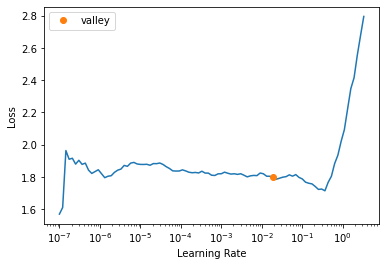

In [36]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.lr_find()

In [37]:
learn.fit_one_cycle(5, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.960600,0.967294,00:09
1,0.893643,0.906712,00:09
2,0.749865,0.865688,00:09
3,0.551776,0.843738,00:08
4,0.381343,0.846147,00:09


### Training with collab_learner

In [38]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.952338,0.972281,00:08
1,0.896477,0.905513,00:08
2,0.772317,0.868070,00:08
3,0.574562,0.847296,00:08
4,0.391383,0.848967,00:08
